# Calculate the mean value of the USD-EUR

In [301]:
import pandas as pd
import numpy as np
import json
import datetime
import pickle
import functions as fn
import matplotlib.pyplot as plt
%matplotlib inline
import requests

## Select wanted exchange rate

In [363]:
exchange_currency = input()

EUR


In [364]:
desired_currency = input()

USD


## Import data to calculate the exchange rate

In [344]:
#Retrieving my api keys information to access the Google API.
def get_keys(path):
    with open(path) as f:
        api_key = keys['api_key']
        return api_key

In [349]:
def get_fx_rates(url, exchange_currency, desired_currency):
    """Function that returns the 100 day FX rate history for the currency wished to
    be exchanged in json format."""
    api_key = get_keys(url)
    url = 'https://www.alphavantage.co/query?'
    function_input = 'FX_DAILY'
    from_symbol_input = f'{exchange_currency}'
    to_symbol_input = f'{desired_currency}'
    url_params = (f"""function={function_input}&from_symbol={from_symbol_input}&to_symbol={to_symbol_input}&apikey={api_key}""")
    request_url = url + url_params
    response = requests.get(request_url)
    return response

In [ ]:
response_json = get_fx_rates(url, exchange_currency, desired_currency)

In [396]:
def get_adjusted_rate(response_json):
    "Function that converts json into pd dataframe with historic adj closed prices."
    response_dict = {}
    for key, val in response.json()['Time Series FX (Daily)'].items():
        response_dict[key] = float(val['4. close'])
    response_df = pd.DataFrame.from_dict(response_dict, 'index')
    response_df.columns = ['Adj Close Price']
    response_df = response_df.reindex(index=response_df.index[::-1])
    return response_df

In [397]:
response_df = get_adjusted_rate(response_json)

## Graphing the exchange rate

In [400]:
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
def get_bollinger_bands(response_df):
    """Function that returns the bollinger bands for the exchange rate in question."""
    response_df['30 Day MA'] = response_df['Adj Close Price'].rolling(window=20).mean()
    response_df['30 Day STD'] = response_df['Adj Close Price'].rolling(window=20).std()
    response_df['Upper Band'] = response_df['30 Day MA'] + (response_df['30 Day STD'] * 2)
    response_df['Lower Band'] = response_df['30 Day MA'] - (response_df['30 Day STD'] * 2)
    return response_df

In [401]:
response_bb_df = get_bollinger_bands(response_df)

In [545]:
today = date.today()

In [546]:
def get_graphical_view(response_df, exchange_currency, desired_currency, today):
    """Function that returns a graphic view of the exchange rate in question
    and the corresponding bollinger bands."""
    # We only want to show the previous month, therefore subset the dataframe
    one_month_ago = (today.replace(day=1) - datetime.timedelta(days=1)).replace(day=today.day).strftime("%Y-%m-%d")
    date_15_days_ago = (today - datetime.timedelta(days=15)).strftime("%Y-%m-%d")
    response_df = response_df.loc[(response_df.index >= one_month_ago) & (response_df.index <= today.strftime("%Y-%m-%d"))]
    
    # set style, empty figure and axes
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12,6), facecolor='w')
    ax = fig.add_subplot(111)
    
    # Get index values for the X axis for exchange rate DataFrame
    x_axis = response_df.index
    
    # Plot shaded 21 Day Bollinger Band for exchange rate
    ax.fill_between(x_axis, response_df['Upper Band'], response_df['Lower Band'], color='white')
    
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(x_axis, response_df['Adj Close Price'], color='blue', lw=2)
    #ax.plot(x_axis, response_df['30 Day MA'], color='black', lw=2)
    ax.plot(x_axis, response_df['Upper Band'], color='green', lw=2)
    ax.plot(x_axis, response_df['Lower Band'], color='red', lw=2)
    ax.set_xticks([one_month_ago, date_15_days_ago, today.strftime("%Y-%m-%d")])
    
    # Set Title & Show the Image
    ax.set_title(f'30 Day Bollinger Band For {exchange_currency}/{desired_currency} rate')
    ax.set_ylabel(f'Value of 1 {exchange_currency} in {desired_currency}')
    ax.legend(['Adj Close Price', f'Strong {exchange_currency}', f'Weak {exchange_currency}'])
    
    # Compare the value of the exchange rate currencies
    compare = response_bb_df.loc[response_bb_df.index == today.strftime("%Y-%m-%d")]
    if compare['Adj Close Price'].values > compare['Upper Band'].values:
        print(f'The {exchange_currency} is strong, consider making your international transaction today.')
    elif compare['Adj Close Price'].values > compare['Lower Band'].values:
        print(f"The {exchange_currency} is currently trading according to its boundaries.")
    else:
        print(f"The {exchange_currency} is weak, consider making your international transaction another day.")
    return plt.show();

The EUR is currently trading according to its boundaries.


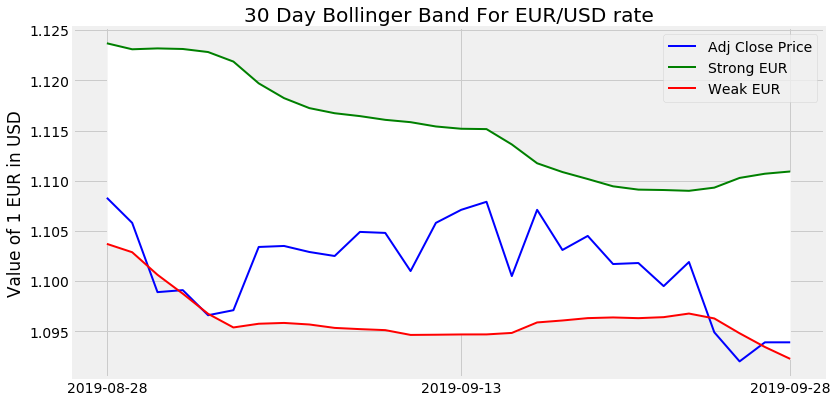

In [547]:
response_graphic = get_graphical_view(response_bb_df, exchange_currency, desired_currency, today)

There is a problem with the dates on the x axis so check that out